## Data Generation

In [516]:
import numpy as np
import sklearn.linear_model as lm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [517]:
import warnings

warnings.filterwarnings('ignore')

In [823]:
def get_grid(n, D, x_min, x_max):
    """Генерирует сетку размера n^D x D"""
    xn = np.linspace(x_min, x_max, n)
    xn = np.meshgrid(*([xn]*D))
    return np.concatenate([xi.reshape((n**D, 1)) for xi in xn], axis=1)


def gen_data(n, D, x_min, x_max, f_target):
    """Возвращает аргументы и значения для заданной функции"""
    X = get_grid(n, D, x_min, x_max)
    N = X.shape[0]
    y = f_target(X)
    y = np.array([int(el < 0) for el in y]) if D > 1 else y
    return X, y

## Задание 1

Create dataset for binary classification task (binary crossentropy), where k-NN perfoms worse than logistic regression

In [742]:
def f_target(X):
    return np.sin(X) + 10

X, y = gen_data(1000, 1, 0, 10, f_target)

In [743]:
X.shape, y.shape

((1000, 1), (1000, 1))

In [744]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

Визуализируем тестовую выборку:

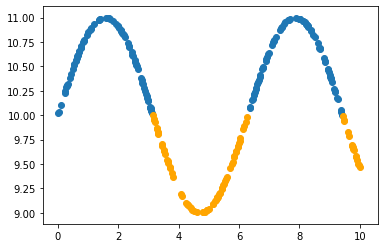

In [746]:
class_1 = X_test[y_test > 10]
class_2 = X_test[y_test <= 10]
plt.scatter(class_1, y_test[y_test > 10])
plt.scatter(class_2, y_test[y_test <= 10], c="orange")

Пробуем линейную регрессию. Подбираем параметры (формальное действие, у линейной регрессии особенно не из чего выбирать) на валидационной выборке, обучаем модель на тренировочной и смотрим на предикт на тестовой.

In [747]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

LR = LinearRegression()

params = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

# Тюним параметры
LR_GS = GridSearchCV(LR, params, cv=10, verbose=1).fit(X_valid, y_valid)

best_params = LR_GS.best_params_
print("Лучшие параметры:", best_params)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Лучшие параметры: {'fit_intercept': True, 'normalize': False}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


In [768]:
best_LR = LinearRegression(fit_intercept=True, normalize=True)
best_LR.fit(X_train, y_train)
LR_y_pred = best_LR.predict(X_test)
metric = accuracy_score((y_test > 10).astype(np.int_), (LR_y_pred > 10).astype(np.int_))
print("Метрика на тестовых данных:", metric)

Метрика на тестовых данных: 1.0


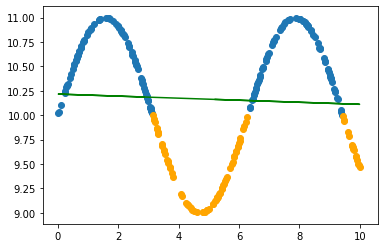

In [750]:
plt.scatter(class_1, y_test[y_test > 10])
plt.scatter(class_2, y_test[y_test <= 10], c="orange")
plt.plot(X_test, best_LR.predict(X_test), color = "green")

Валидируем количество соседей, обучаем и тестируем КНН классификацию.

In [761]:
from sklearn.neighbors import KNeighborsClassifier

kNN = KNeighborsClassifier()

params = {
    'n_neighbors': range(1, 30)
}

# Тюним параметры
kNN_GS = GridSearchCV(kNN, params, cv=10, verbose=1).fit(X_valid, (y_valid > 0.05).astype(np.int_))

best_params = kNN_GS.best_params_
print("Лучшие параметры:", best_params)

Fitting 10 folds for each of 29 candidates, totalling 290 fits
Лучшие параметры: {'n_neighbors': 20}


In [758]:
best_kNN = KNeighborsClassifier(n_neighbors=20)
best_kNN.fit(X_train, (y_train > 10).astype(np.int_))
kNN_y_pred = best_kNN.predict(X_test)
metric = accuracy_score((y_test > 10).astype(np.int_), kNN_y_pred)
print("Метрика на тестовых данных:", metric)

Метрика на тестовых данных: 0.992


## Выводы

    Здесь KNN сработала хуже, так как данные были основаны на функции синусоиды, так как из-за ее изгибов создается спорная ситуация: объект на матричном пространстве может лежать близко к центру тяжести класса, но на самом деле оказаться частью совсем другого изгиба, принадлежащему к другому классу, и происходит конфликт.
    В то же время линейной регрессии очень просто провести прямую и четко разделить две части графика.

## Задание 2

Create dataset for binary classification task (binary crossentropy), where logistic regression perfoms worse than k-NN

Случайно генерируем данные, в которых таргет будет коррелировать так же нелинейно. Добавляю дополнительный признак, чтобы запутать модели.

In [697]:
def f_target(X):
    return np.sin(X.sum(axis=1))

X, y = gen_data(30, 2, 0, 10, f_target)

In [698]:
X.shape, y.shape

((900, 2), (900,))

In [699]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

Визуализируем тестовую выборку:

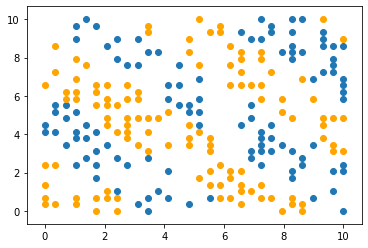

In [509]:
class_1 = X_test[y_test == 1]
class_2 = X_test[y_test == 0]
plt.scatter(class_1[:,0], class_1[:,1])
plt.scatter(class_2[:,0], class_2[:,1], c="orange")

Делаем все то же, что и в задании 1, для линейной регресии.

In [510]:
LR = LinearRegression()

params = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

# Тюним параметры
LR_GS = GridSearchCV(LR, params, cv=10, verbose=1).fit(X_valid, y_valid)

best_params = LR_GS.best_params_
print("Лучшие параметры:", best_params)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Лучшие параметры: {'fit_intercept': True, 'normalize': True}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


In [511]:
best_LR = LinearRegression(fit_intercept=True, normalize=True)
best_LR.fit(X_train, y_train)
LR_y_pred = best_LR.predict(X_test)
metric = accuracy_score(y_test, (LR_y_pred > 0.5).astype(np.int_))
print("Метрика на тестовых данных:", metric)

Метрика на тестовых данных: 0.43555555555555553


Визуализируем прямую, определенную моделью:

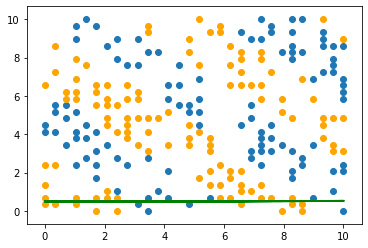

In [512]:
plt.scatter(class_1[:,0], class_1[:,1])
plt.scatter(class_2[:,0], class_2[:,1], c="orange")
plt.plot(X_test, best_LR.predict(X_test), color = "green")

In [513]:
kNN = KNeighborsClassifier()

params = {
    'n_neighbors': range(1, 30)
}

# Тюним параметры
kNN_GS = GridSearchCV(kNN, params, cv=10, verbose=1).fit(X_valid, y_valid)

best_params = kNN_GS.best_params_
print("Лучшие параметры:", best_params)

Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Лучшие параметры: {'n_neighbors': 1}


[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    0.5s finished


In [700]:
best_kNN = KNeighborsClassifier(n_neighbors=1)
best_kNN.fit(X_train, y_train)
kNN_y_pred = best_kNN.predict(X_test)
metric = accuracy_score(y_test, (kNN_y_pred > 0.5).astype(np.int_))
print("Метрика на тестовых данных:", metric)

Метрика на тестовых данных: 0.88


Визуализируем, как определила классы модель:

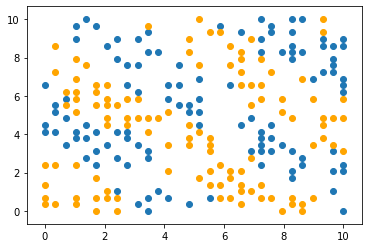

In [515]:
model_class_2 = X_test[(kNN_y_pred > 0.5).astype(np.int_) == 0]
model_class_1 = X_test[(kNN_y_pred > 0.5).astype(np.int_) == 1]
plt.scatter(model_class_1[:, 0], model_class_1[:, 1])
plt.scatter(model_class_2[:, 0], model_class_2[:, 1], c="orange")

## Выводы

    Как можно увидеть, при данном датасете KNN отработала хуже регресии. Это обусловлено тем, что таргет датасета генерировался при помощи нелинейной фунции - синуса, что затрудняет определение регрессией прямой, позволяющей однозначно разделить плоскость на два класса. Как можно видеть на графиках, точки разных классов перемешиваются на всей плоскости данных. Линейная модель попыталась сделать прямую, и у нее, конечно, ничего не получилось.
        Для KNN эта задача более посильна, так как модель определяет группы точек схожего класса на заданной плоскости при помощи косинусной меры. На графике видно, что это вполне возможно. График данных и график результата предикта даже очень схож. Основной проблемой является подбор количества ближаших соседей для классификации, что проделано при помощи грид серча.

## Задание 3

Create dataset for binary classification task (binary crossentropy), where k-NN with cosine distance perfoms better than k-NN with euclidean distance

In [869]:
def f_target(X):
    return [num * (-1)**i for i, num in enumerate(np.tanh(np.sum(X, axis=1)))]

X, y = gen_data(100, 2, 1, 10, f_target)

In [870]:
X.shape, y.shape

((10000, 2), (10000,))

In [874]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

Визуализируем данные. Получится шумная дичь.

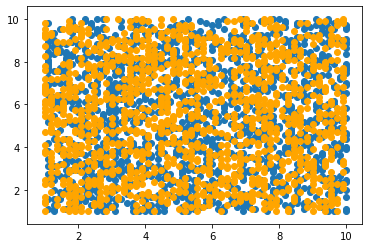

In [875]:
class_1 = X_test[y_test == 1]
class_2 = X_test[y_test == 0]
plt.scatter(class_1[:,0], class_1[:,1])
plt.scatter(class_2[:,0], class_2[:,1], c="orange")

В этом случае не буду валидировать каждую модель, так как хочу поставить их в равные условия. Поэтому выберу параметр количества соседей от балды.

In [881]:
from sklearn.metrics.pairwise import cosine_similarity

cos_kNN = KNeighborsClassifier(n_neighbors=20, metric='cosine')
cos_kNN.fit(X_train, (y_train > 0).astype(np.int_))
cos_y_pred = cos_kNN.predict(X_test)
metric = accuracy_score((y_test > 0).astype(np.int_), cos_y_pred)
print("Метрика на тестовых данных с косинусной метрикой:", metric)

Метрика на тестовых данных с косинусной метрикой: 0.4488


Визуализируем, как определила классы модель.

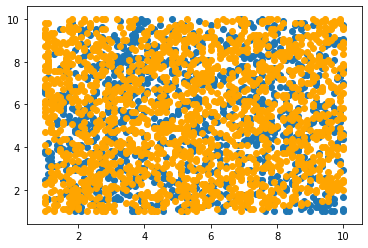

In [878]:
model_class_2 = X_test[cos_y_pred == 0]
model_class_1 = X_test[cos_y_pred == 1]
plt.scatter(model_class_1[:, 0], model_class_1[:, 1])
plt.scatter(model_class_2[:, 0], model_class_2[:, 1], c="orange")

In [880]:
from sklearn.metrics.pairwise import cosine_similarity

euc_kNN = KNeighborsClassifier(n_neighbors=20, metric='euclidean')
euc_kNN.fit(X_train, (y_train > 0).astype(np.int_))
euc_y_pred = euc_kNN.predict(X_test)
metric = accuracy_score((y_test > 0).astype(np.int_), euc_y_pred)
print("Метрика на тестовых данных с евклидовой метрикой:", metric)

Метрика на тестовых данных с евклидовой метрикой: 0.4044


Тут тоже визуализируем классификацию.

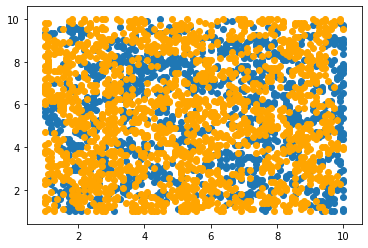

In [879]:
model_class_2 = X_test[euc_y_pred == 0]
model_class_1 = X_test[euc_y_pred == 1]
plt.scatter(model_class_1[:, 0], model_class_1[:, 1])
plt.scatter(model_class_2[:, 0], model_class_2[:, 1], c="orange")

## Выводы

    Косинусная близость отработала хуже, чем евклидова, так как геометрический смысл косинусной меры состоит в том, что для нее важен показатель угла между точками, а в то время как для евклидовой метрики важно собственно линейное расстояние между точками.
    Никакой заслуги генерации данных в результате нет, просто так получилось, просто косинусная мера случайно собрала больше точек нужного класса. На графике можно разглядеть лучи "векторов", которые косинусная мера посчитала близкими, там видно, что эти лучи имеют одинаковый угол и, как следствие, они одинаково близки. Евклидова метрика попыталась найти одинаковые группы точек, но у нее не особо получилось, да и не могло - данные сгенерированы очень шумно.